In [2]:
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.stats import mode


In [3]:
# Load features and labels
X_train = np.load("python_ML/data/features/X_train.npy")
X_val   = np.load("python_ML/data/features/X_val.npy")
X_test  = np.load("python_ML/data/features/X_test.npy")

y_train = np.load("python_ML/data/features/y_train.npy")
y_val   = np.load("python_ML/data/features/y_val.npy")
y_test  = np.load("python_ML/data/features/y_test.npy")

with open("python_ML/data/features/class_names.json", "r") as f:
    class_names = json.load(f)

print("Train features:", X_train.shape)
print("Val features:", X_val.shape)
print("Test features:", X_test.shape)
print("Class names:", class_names)


Train features: (594, 2048)
Val features: (127, 2048)
Test features: (128, 2048)
Class names: {'beagle': 0, 'chihuahua': 1, 'german_shepherd': 2, 'golden_retriever': 3, 'pug': 4}


In [4]:
# Combine into full dataset
X = np.concatenate([X_train, X_val, X_test], axis=0)
y = np.concatenate([y_train, y_val, y_test], axis=0)

print("Full dataset shape:", X.shape)
print("Full label shape:", y.shape)


Full dataset shape: (849, 2048)
Full label shape: (849,)


In [5]:
# Run K-Means
kmeans = KMeans(
    n_clusters=5,
    init="k-means++",
    n_init=10,
    max_iter=300,
    random_state=42
)

kmeans.fit(X)
cluster_labels = kmeans.labels_
print("K-Means completed. Inertia:", kmeans.inertia_)


K-Means completed. Inertia: 148262.015625


In [6]:
# Map clusters → real labels
def map_clusters_to_labels(true_labels, cluster_labels, k=5):
    mapped = np.zeros_like(cluster_labels)
    for i in range(k):
        mask = (cluster_labels == i)
        if np.sum(mask) == 0:
            continue
        mapped[mask] = mode(true_labels[mask])[0]
    return mapped

predicted_labels = map_clusters_to_labels(y, cluster_labels, k=5)


In [7]:
# Accuracy
accuracy = accuracy_score(y, predicted_labels)
print("K-Means Clustering Accuracy:", accuracy)


K-Means Clustering Accuracy: 0.9882214369846879


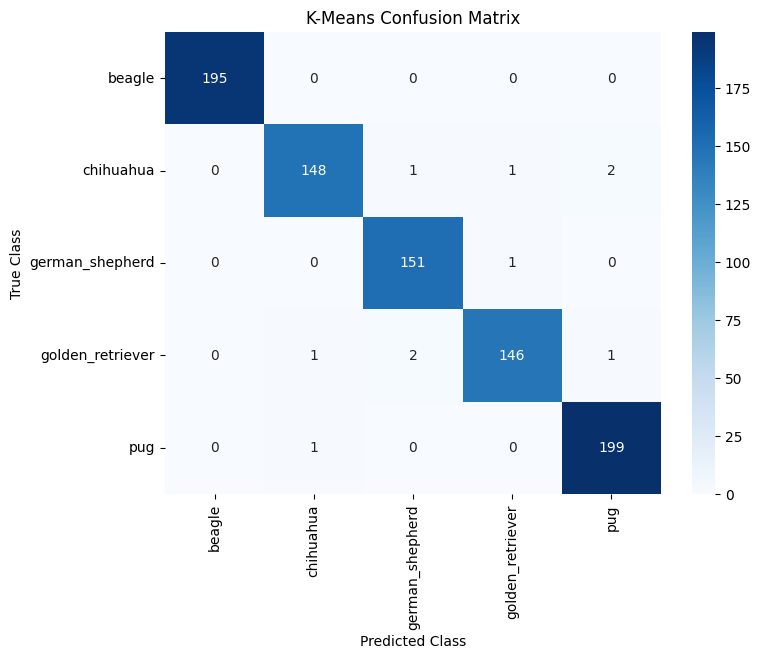

In [8]:
# Confusion Matrix
cm = confusion_matrix(y, predicted_labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("K-Means Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()


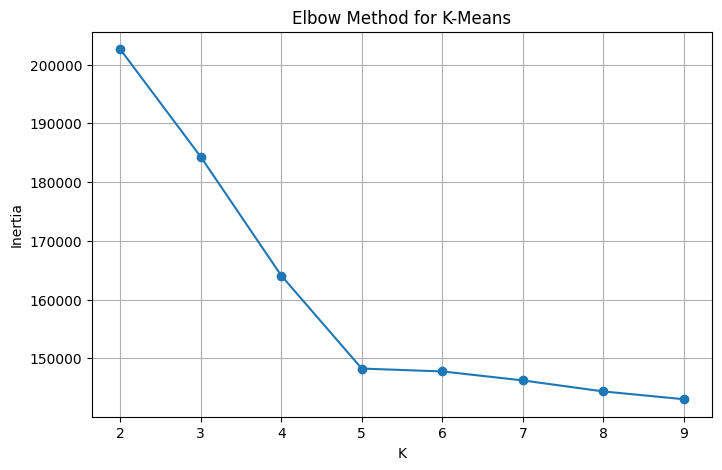

In [9]:
# Elbow Curve
inertia_values = []
K_values = range(2, 10)

for k in K_values:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X)
    inertia_values.append(model.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_values, inertia_values, marker="o")
plt.title("Elbow Method for K-Means")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


In [10]:
# 1. Define the features (X) and true labels (y) for clustering
X = X_train 
y = y_train 

# 2. DEFINE THE MISSING VARIABLE: class_labels
if 'class_names' in locals():
    class_labels = list(class_names.keys())
else:
    print("WARNING: 'class_names' dictionary not found. Using generic labels.")
    class_labels = np.unique(y)

K_FINAL = 5 
print(f"Training K-Means model with K={K_FINAL}...")
model = KMeans(n_clusters=K_FINAL, random_state=42, n_init='auto')
model.fit(X)

print("Setup complete.")

Training K-Means model with K=5...
Setup complete.


Number of clusters (K): 5

--- Cluster-to-Class Mapping ---
Cluster 0 (Size: 137) -> Majority Class: beagle (Index: 0)
Cluster 1 (Size: 142) -> Majority Class: pug (Index: 4)
Cluster 2 (Size: 104) -> Majority Class: golden_retriever (Index: 3)
Cluster 3 (Size: 106) -> Majority Class: german_shepherd (Index: 2)
Cluster 4 (Size: 105) -> Majority Class: chihuahua (Index: 1)

K-Means Clustering Accuracy (Purity) on Data: 0.9899


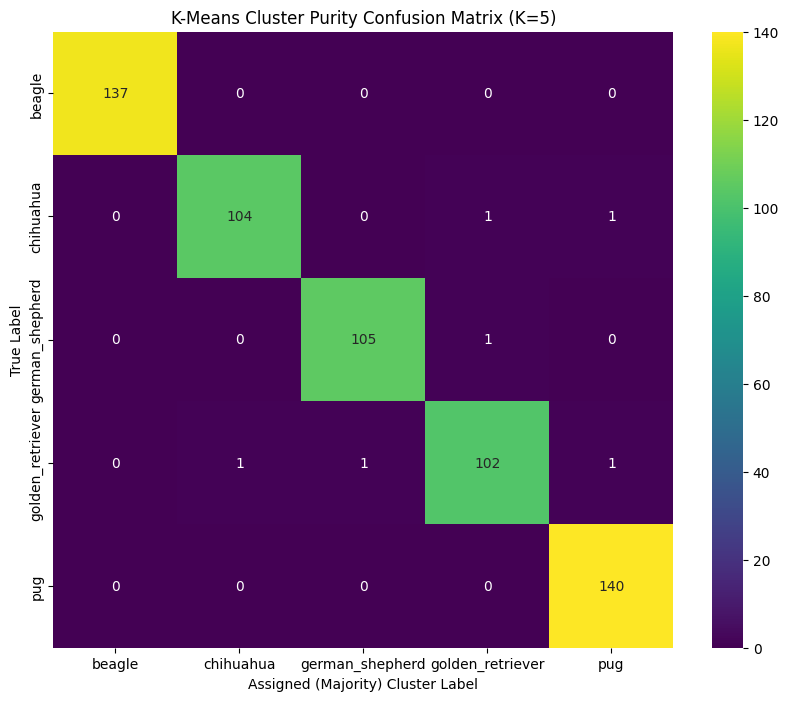

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# 1. Predict cluster labels for the data
clusters = model.predict(X)
n_clusters = model.n_clusters
print(f"Number of clusters (K): {n_clusters}")

# 2. Map each cluster label to the most frequent true class label (Purity Mapping)
labels_assigned = np.zeros_like(clusters)
cluster_mapping = {}
print("\n--- Cluster-to-Class Mapping ---")
for i in range(n_clusters):
    mask = (clusters == i)
    cluster_true_labels = y[mask]
    
    if len(cluster_true_labels) > 0:
        counts = np.bincount(cluster_true_labels)
        majority_class_index = np.argmax(counts) 
        
        majority_class_name = class_labels[majority_class_index]
        cluster_mapping[i] = majority_class_index
        print(f"Cluster {i} (Size: {len(cluster_true_labels)}) -> Majority Class: {majority_class_name} (Index: {majority_class_index})")
    else:
        print(f"Cluster {i} is empty.")
        cluster_mapping[i] = -1

# 3. Assign the majority class label to all points in that cluster
for cluster_idx, class_idx in cluster_mapping.items():
    if class_idx != -1:
        labels_assigned[clusters == cluster_idx] = class_idx

# 4. Calculate Clustering Accuracy (Purity)
purity_accuracy = accuracy_score(y, labels_assigned)
print(f"\nK-Means Clustering Accuracy (Purity) on Data: {purity_accuracy:.4f}")

# 5. Visualize the Cluster Purity using a Confusion Matrix
cm = confusion_matrix(y, labels_assigned)


plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='viridis',
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.title(f'K-Means Cluster Purity Confusion Matrix (K={n_clusters})')
plt.ylabel('True Label')
plt.xlabel('Assigned (Majority) Cluster Label')
plt.show()

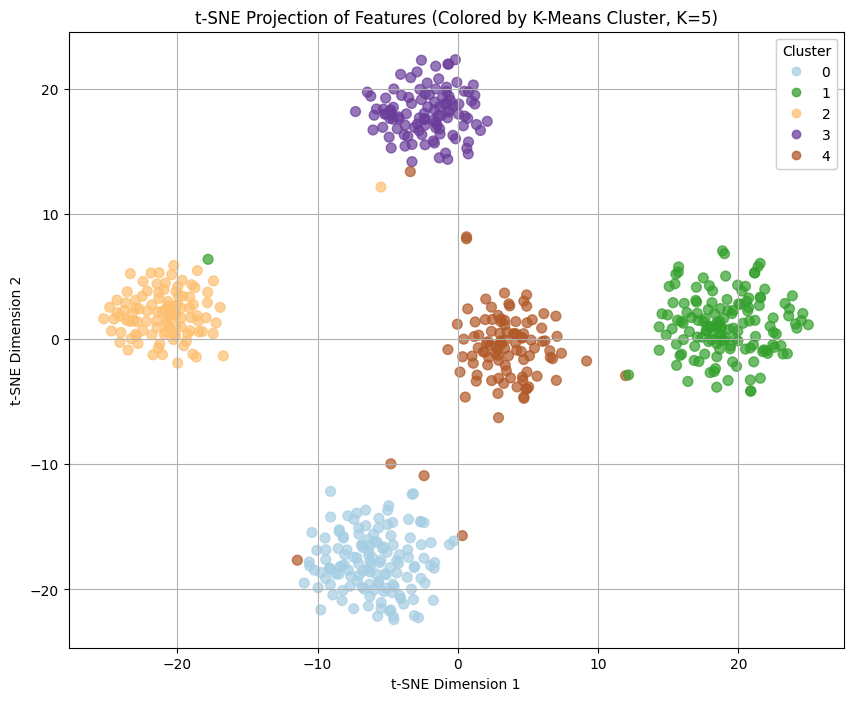

In [12]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# 1. Standardize features (crucial for t-SNE)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Run t-SNE on the features
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_jobs=-1)
X_tsne = tsne.fit_transform(X_scaled)

# 3. Plot the t-SNE projection, colored by the K-Means cluster
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=clusters,
    cmap='Paired',
    s=50,
    alpha=0.7
)

# Add a legend for the clusters
legend1 = plt.legend(
    *scatter.legend_elements(),
    title="Cluster",
    loc="best"
)
plt.gca().add_artist(legend1)

plt.title(f't-SNE Projection of Features (Colored by K-Means Cluster, K={model.n_clusters})')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)
plt.show()